### 1. Library Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from imblearn.over_sampling import SMOTE
from lazypredict.Supervised import LazyClassifier
from tqdm import tqdm
import joblib

# Patch tqdm to support LazyPredict in non-notebook environments
import lazypredict.Supervised
lazypredict.Supervised.notebook_tqdm = tqdm


### 2. Synthetic Dataset Generation

In [2]:
# Configuration
n_samples = 11515
fraud_ratio = 0.025
n_frauds = int(n_samples * fraud_ratio)
random.seed(42)
np.random.seed(42)
fake = Faker()

# Generate base classification data
X, y = make_classification(n_samples=n_samples,
                           n_features=15,
                           n_informative=6,
                           n_redundant=4,
                           weights=[1 - fraud_ratio],
                           class_sep=1.2,
                           flip_y=0.01,
                           random_state=42)

# Create initial DataFrame
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(15)])
df['isFraud'] = y

# Add realistic financial and transactional features
df['amount'] = np.round(np.abs(df['feature_0']) * 10000, 2)
df['oldbalanceOrg'] = df['amount'] + np.abs(df['feature_1']) * 10000
df['newbalanceOrig'] = df['oldbalanceOrg'] - df['amount']
df['oldbalanceDest'] = np.abs(df['feature_2']) * 5000
df['newbalanceDest'] = df['oldbalanceDest'] + df['amount']

# Add categorical and behavioral features
df['transactionType'] = [random.choice(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'MERCHANT']) for _ in range(n_samples)]
df['deviceType'] = [random.choice(['mobile', 'desktop', 'tablet']) for _ in range(n_samples)]
df['region'] = [random.choice(['North', 'South', 'East', 'West']) for _ in range(n_samples)]

# Add temporal features
base_time = pd.Timestamp('2023-01-01')
df['timestamp'] = [base_time + pd.Timedelta(seconds=random.randint(0, 3600 * 24 * 90)) for _ in range(n_samples)]
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

# Behavioral patterns
df['txnCount24h'] = np.random.poisson(3, n_samples)
df['avgAmount30d'] = df['amount'] * np.random.uniform(0.7, 1.3, n_samples)

# Flags
df['isForeignTransaction'] = np.random.binomial(1, 0.05, n_samples)
df['isHighRiskCountry'] = np.random.binomial(1, 0.03, n_samples)
df['hasSecureAuth'] = np.random.binomial(1, 0.95, n_samples)

# Add user ID (to be removed later)
df['userID'] = [fake.uuid4() for _ in range(n_samples)]

# Drop internal helper features
df.drop(columns=[col for col in df.columns if 'feature_' in col], inplace=True)


### 3. Data Preprocessing

In [3]:
# Encode categorical variables
label_enc_cols = ['transactionType', 'deviceType', 'region']
for col in label_enc_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Drop non-numeric identifiers
df.drop(columns=['userID', 'timestamp'], inplace=True)

# Confirm structure
print(df.shape)
print(df.info())
print(df.describe())


(11515, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11515 entries, 0 to 11514
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   isFraud               11515 non-null  int64  
 1   amount                11515 non-null  float64
 2   oldbalanceOrg         11515 non-null  float64
 3   newbalanceOrig        11515 non-null  float64
 4   oldbalanceDest        11515 non-null  float64
 5   newbalanceDest        11515 non-null  float64
 6   transactionType       11515 non-null  int64  
 7   deviceType            11515 non-null  int64  
 8   region                11515 non-null  int64  
 9   hour                  11515 non-null  int32  
 10  dayofweek             11515 non-null  int32  
 11  txnCount24h           11515 non-null  int32  
 12  avgAmount30d          11515 non-null  float64
 13  isForeignTransaction  11515 non-null  int32  
 14  isHighRiskCountry     11515 non-null  int32  
 15  hasSecu

### 4. Exploratory Data Analysis (EDA)

isFraud                 0
amount                  0
oldbalanceOrg           0
newbalanceOrig          0
oldbalanceDest          0
newbalanceDest          0
transactionType         0
deviceType              0
region                  0
hour                    0
dayofweek               0
txnCount24h             0
avgAmount30d            0
isForeignTransaction    0
isHighRiskCountry       0
hasSecureAuth           0
dtype: int64


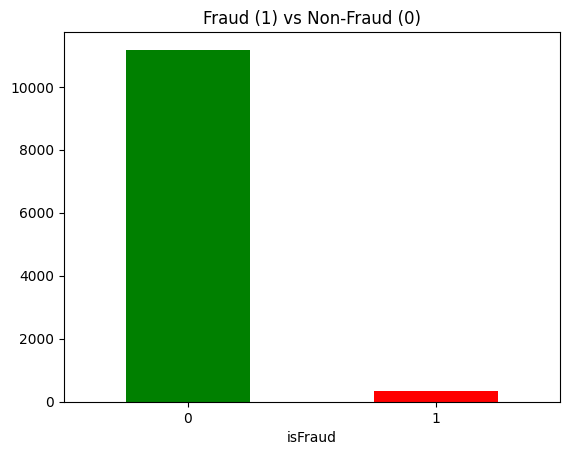

Fraud Ratio: 0.0294


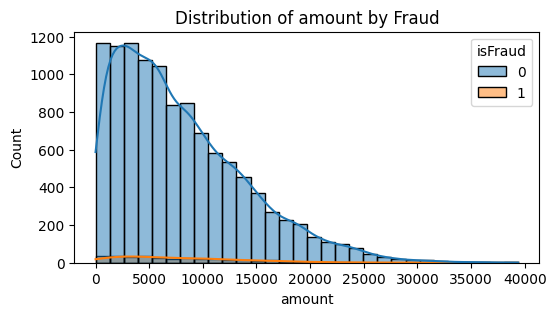

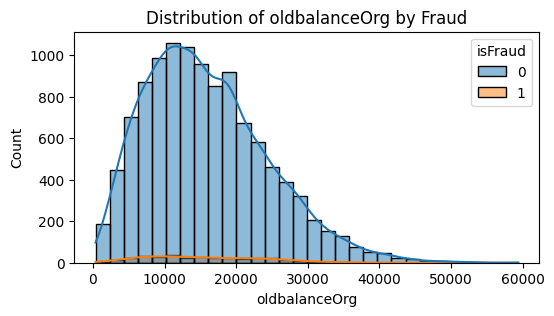

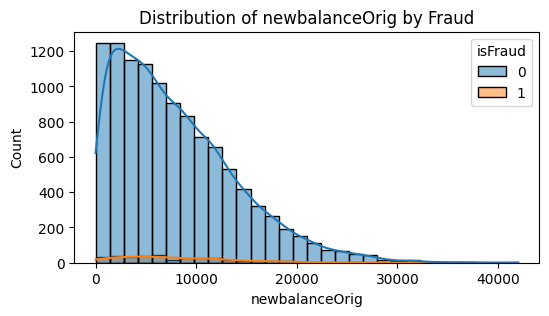

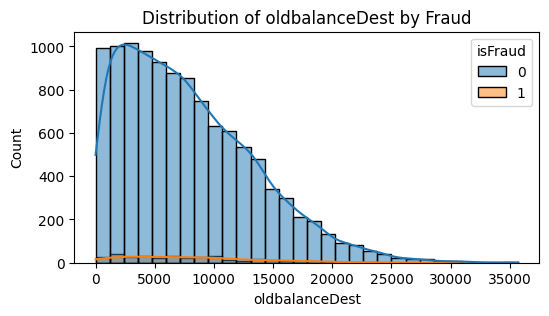

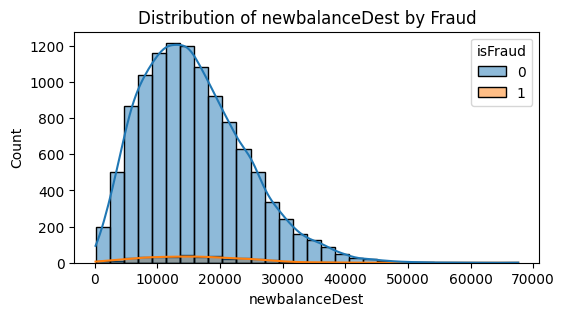

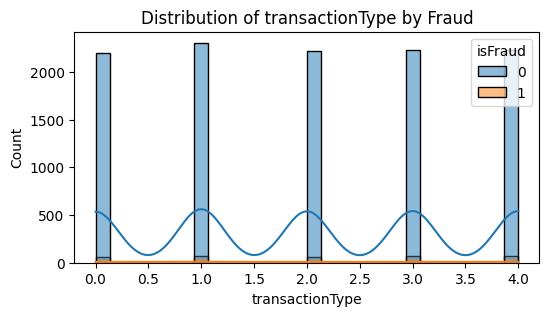

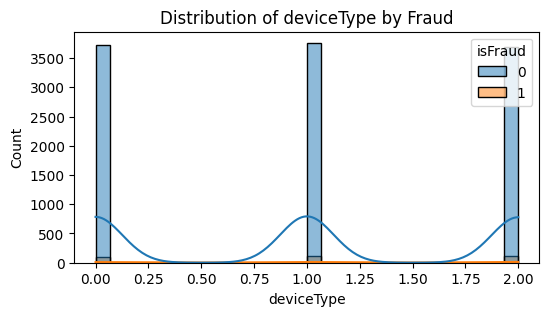

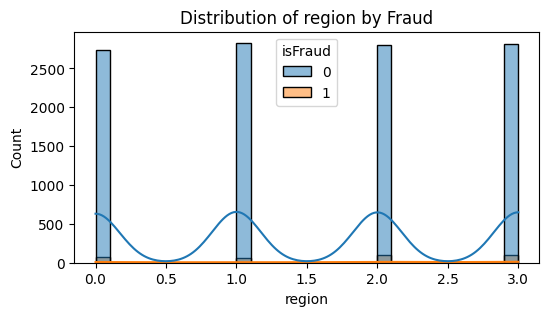

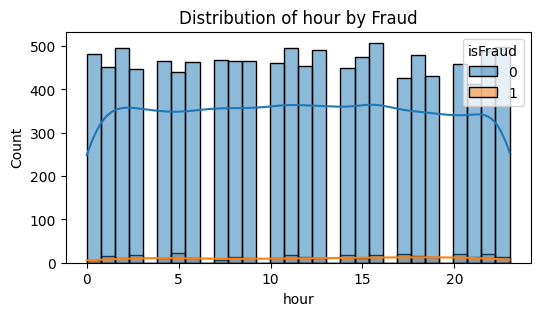

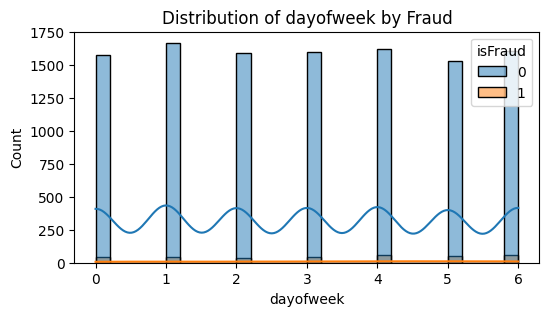

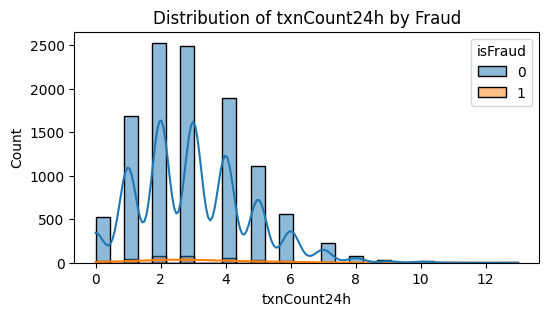

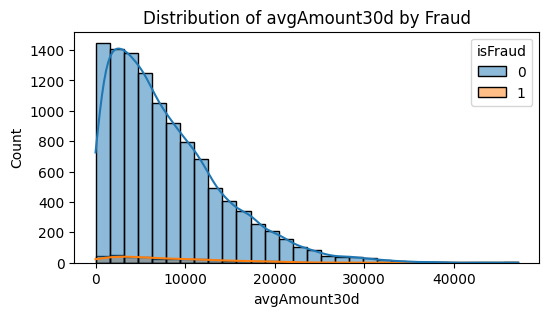

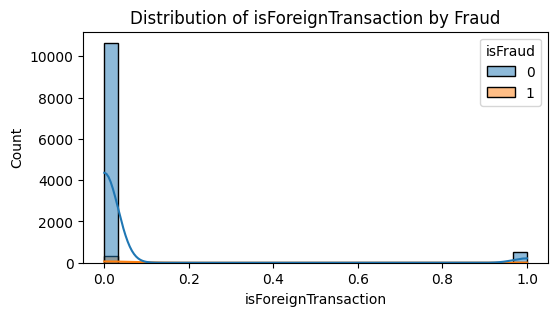

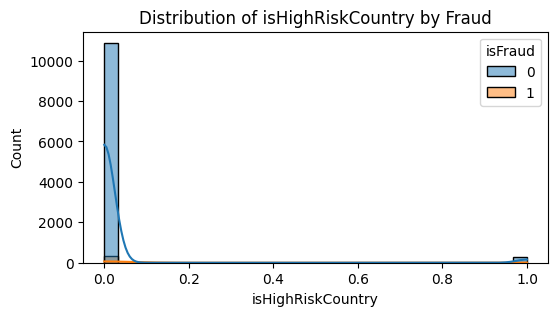

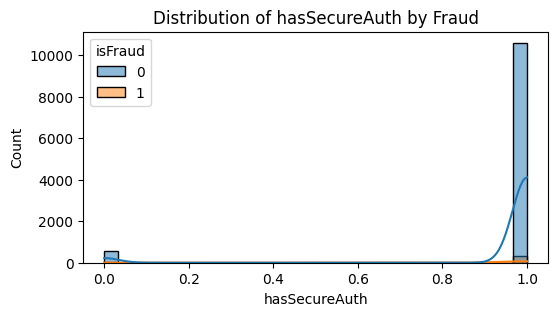

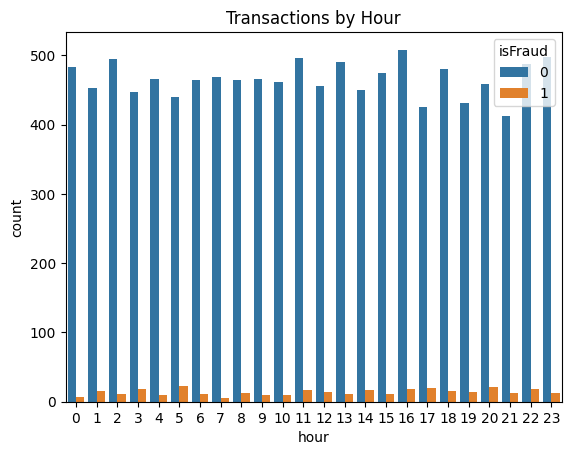

In [4]:
# Missing values
print(df.isnull().sum())

# Fraud balance
df['isFraud'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Fraud (1) vs Non-Fraud (0)')
plt.xticks(rotation=0)
plt.show()
print(f"Fraud Ratio: {df['isFraud'].mean():.4f}")

# Distributions of features
for col in df.select_dtypes(include='number').columns:
    if col != 'isFraud':
        plt.figure(figsize=(6, 3))
        sns.histplot(data=df, x=col, hue='isFraud', kde=True, bins=30)
        plt.title(f'Distribution of {col} by Fraud')
        plt.show()

# Hourly fraud pattern
sns.countplot(data=df, x='hour', hue='isFraud')
plt.title('Transactions by Hour')
plt.show()


### 5. Feature Importance

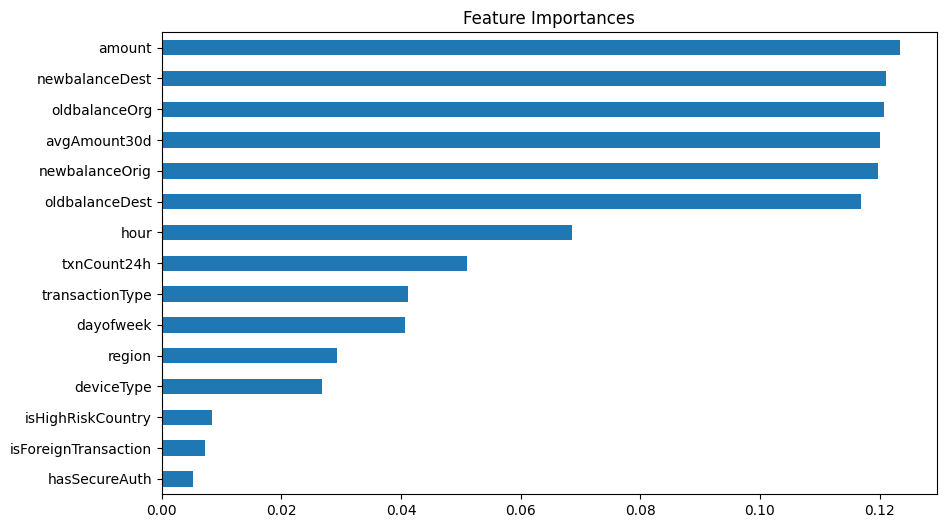

In [5]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Visualize importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importances')
plt.show()


### 6. Class Balancing and Scaling

In [6]:
# SMOTE for imbalance
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_resampled)
x_test_scaled = scaler.transform(X_test)


### 7. Model Benchmarking with LazyPredict

In [7]:
clf = LazyClassifier(verbose=0, ignore_warnings=True)
models, predictions = clf.fit(x_train_scaled, x_test_scaled, y_train_resampled, y_test)

# Top models
print("\nTop 10 Classifier Results:")
print(models.head(10))


 84%|████████▍ | 27/32 [00:30<00:06,  1.30s/it]  File "c:\Users\karth\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\karth\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\karth\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        sta

[LightGBM] [Info] Number of positive: 7823, number of negative: 7823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1600
[LightGBM] [Info] Number of data points in the train set: 15646, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Top 10 Classifier Results:
                            Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                        
ExtraTreeClassifier             0.82               0.51     0.51      0.88   
XGBClassifier                   0.91               0.51     0.51      0.92   
DummyClassifier                 0.97               0.50     0.50      0.96   
GaussianNB                      0.18               0.50     0.50      0.27   
Ext

### 8. XGBClassifier Evaluation Code

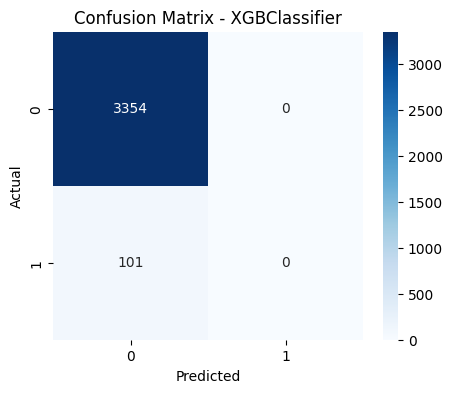

Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3354
           1       0.00      0.00      0.00       101

    accuracy                           0.97      3455
   macro avg       0.49      0.50      0.49      3455
weighted avg       0.94      0.97      0.96      3455



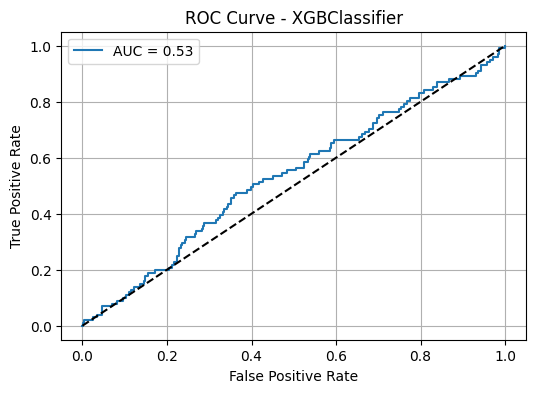

ROC AUC Score: 0.5337


In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Train the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# 2. Predictions
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBClassifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# 5. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBClassifier")
plt.legend()
plt.grid(True)
plt.show()

# 6. Print AUC Score
print(f"ROC AUC Score: {auc:.4f}")


###  9. Save Final Model and Scaler

In [ ]:
joblib.dump(xgb, 'fraud_model.pkl')
joblib.dump(scaler, 'scaler.pkl')